# Day and Night Image Classifier


The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We'd like to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images!

In [6]:
# Import resources
import cv2
import helpers

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

%matplotlib inline

### Training and Testing Data
The 200 day/night images are separated into training and testing datasets.

- 60% of these images are training images, for you to use as you create a classifier.
- 40% are test images, which will be used to test the accuracy of your classifier.

First, we set some variables to keep track of some where our images are stored:

image_dir_training: the directory where our training image data is stored

image_dir_test: the directory where our test image data is stored

In [9]:
# Image data directions
image_dir_training = "day_night_images/training/"
image_dir_test = "day_night_images/test/"

### Load the datasets
These first few lines of code will load the training day/night images and store all of them in a variable, IMAGE_LIST. This list contains the images and their associated label ("day" or "night").

For example, the first image-label pair in IMAGE_LIST can be accessed by index: IMAGE_LIST[0][:].

In [11]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(image_dir_training)
IMAGE_LIST[0][:] 

(array([[[253, 255, 252],
         [253, 255, 252],
         [253, 255, 252],
         ...,
         [ 75,  93,  93],
         [ 73,  91,  91],
         [ 74,  92,  92]],
 
        [[253, 255, 252],
         [253, 255, 252],
         [253, 255, 252],
         ...,
         [ 77,  95,  95],
         [ 76,  94,  94],
         [ 78,  96,  96]],
 
        [[253, 255, 252],
         [253, 255, 252],
         [253, 255, 252],
         ...,
         [ 75,  93,  93],
         [ 74,  92,  92],
         [ 76,  94,  94]],
 
        ...,
 
        [[108, 112, 113],
         [ 98, 102, 103],
         [ 90,  94,  95],
         ...,
         [ 43,  45,  32],
         [ 45,  47,  34],
         [ 48,  50,  37]],
 
        [[107, 111, 112],
         [ 97, 101, 102],
         [ 90,  94,  95],
         ...,
         [ 42,  44,  31],
         [ 45,  47,  34],
         [ 48,  50,  37]],
 
        [[100, 104, 105],
         [ 91,  95,  96],
         [ 86,  90,  91],
         ...,
         [ 42,  44,  31],
  

## 1. Visualize the input images

Shape of image: (614, 857, 3)
Image label: day


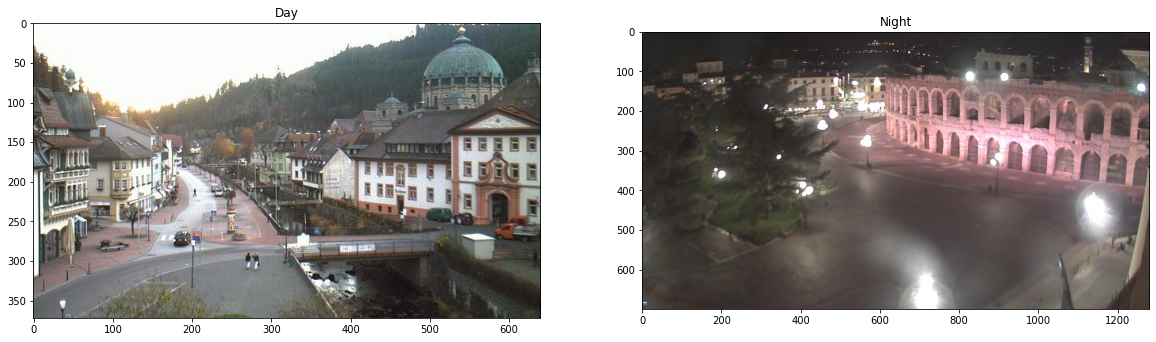

In [12]:
image_index = 3
selected_image = IMAGE_LIST[image_index][0]
selected_label = IMAGE_LIST[image_index][1]

# Print out 1. The shape of the image and 2. The image's label `selected_label`
print(f"Shape of image: {selected_image.shape}")
print(f"Image label: {selected_label}")

## Find first day image
for image_label_pair in IMAGE_LIST:
    if(image_label_pair[1] == "day"):
        image_day = image_label_pair[0]
        break
## Find the first night image
for image_label_pair in IMAGE_LIST:
    if(image_label_pair[1] == "night"):
        image_night = image_label_pair[0]
        break

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Day')
ax1.imshow(image_day)

ax2.set_title('Night')
ax2.imshow(image_night)

# Note the differences between the day and night images
# Any measurable differences can be used to classify these images

## 2. Pre-process the data

After loading in each image, you have to standardize the input and output.




### Input

It's important to make all your images the same size so that they can be sent through the same pipeline of classification steps! Every input image should be in the same format, of the same size, and so on.

#### Standardize the input images
- Resize each image to the desired input size: 600x1100px (hxw).

In [13]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):

    # Resize image so that all standard images are the same size 600x1100.
    standard_im = cv2.resize(image, dsize=(1100, 600), interpolation=cv2.INTER_CUBIC)
    return standard_im

#### Standardize the output
With each loaded image, you also need to specify the expected output. For this, use binary numerical values 0/1 = night/day.


In [18]:
# Examples: 
# encode("day") should return: 1
# encode("night") should return: 0

def encode(label):
    if label == "day":
        numerical_val = 1
    elif label == "night":
        numerical_val = 0

    return numerical_val

### Construct a STANDARDIZED_LIST of input images and output labels.

This function takes in a list of image-label pairs and outputs a standardized list of resized images and numerical labels.

This uses the functions you defined above to standardize the input and output, so those functions must be complete for this standardization to work!

In [19]:
def standardize(image_list):

    #Empty image data array
    standard_list = []

    #Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # Create a numerical label
        binary_label = encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, binary_label))
        
    return standard_list


In [20]:
# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

#### Visualize the standardized data
Display a standardized image from STANDARDIZED_LIST.

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 0


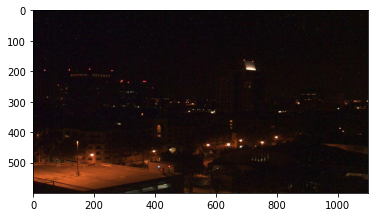

In [22]:
# Display a standardized image and its label

# Select an image by index
image_num = 130
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))

## Feature Extraction

Create a feature that represents the brightness in an image. We'll be extracting the average brightness using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.

### RGB to HSV conversion

Below, a test image is converted from RGB to HSV colorspace and each component is displayed in an image.

Label: 1


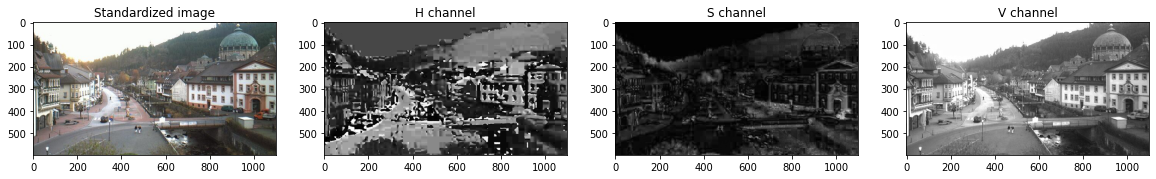

In [24]:
# Convert and image to HSV colorspace
# Visualize the individual color channels

image_num = 0
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

# Convert to HSV
hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

# Print image label
print('Label: ' + str(test_label))

# HSV channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# Plot the original image and the three channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Standardized image')
ax1.imshow(test_im)
ax2.set_title('H channel')
ax2.imshow(h, cmap='gray')
ax3.set_title('S channel')
ax3.imshow(s, cmap='gray')
ax4.set_title('V channel')
ax4.imshow(v, cmap='gray')


### Find the average brightness using the V channel

This function takes in a standardized RGB image and returns a feature (a single value) that represent the average level of brightness in the image. We'll use this value to classify the image as day or night.

In [26]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):

    #convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    #add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])

    # Calculate the average brightness using the area of the image
    height = rgb_image.shape[0]
    width = rgb_image.shape[1]
    area = height*width
    # and the sum calculated above
    avg = sum_brightness/area
    return avg

In [27]:
# Testing average brightness levels
# Look at a number of different day and night images and think about 
# what average brightness value separates the two types of images

# Find the average of the averages from all day and night images

night_brightness = []
day_brightness = []

for image in STANDARDIZED_LIST:
    
    if image[1] == 0:
        night_brightness.append(avg_brightness(image[0]))
    elif image[1] == 1:
        day_brightness.append(avg_brightness(image[0]))

avg_day_brightness = np.mean(day_brightness)
avg_night_brightness = np.mean(night_brightness)
min_day_brightness = np.min(day_brightness)
max_night_brightness = np.max(night_brightness)

print(f"Average of average day brightness from: {avg_day_brightness}")
print(f"Average of average night brightness: {avg_night_brightness}")
print(f"Minimum day brightness: {min_day_brightness}")
print(f"Maximum night brightness: {max_night_brightness}")

Average of average day brightness from: 137.47093169191922
Average of average night brightness: 69.29461650252524
Minimum day brightness: 94.69642878787879
Maximum night brightness: 119.65390606060606


## Classification and Visualizing Error

In this section, we'll turn our average brightness feature into a classifier that takes in a standardized image and returns a predicted_label for that image. This estimate_label function should return a value: 0 or 1 (night or day, respectively).

### Build a complete classifier

Set a threshold that you think will separate the day and night images by average brightness.

In [29]:
# This function should takes in RGB image input:
def estimate_label(rgb_image):

    #Extract average brightness feature from an RGB image
    avg = avg_brightness(rgb_image)

    # Use the avg brightness feature to predict a label (0,1)
    predicted_label = 0

    # Set the value of a threshold that will separate day and night images
    threshold = avg_night_brightness + (avg_day_brightness - avg_night_brightness)/2

    if avg > threshold:
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the pred-cted_label can stay 0 (it is predicted to be "night")

    return predicted_label


In [30]:
## Test out your code by calling the above function and seeing 
# how some of your training data is classified

for i in range(10):
    if estimate_label(STANDARDIZED_LIST[i][0]) == STANDARDIZED_LIST[i][1]:
        print("correct")
    else:
        print("wrong")

correct
correct
correct
correct
correct
correct
correct
correct
correct
wrong


## Testing the classifier

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!

Since we are using a pretty simple brightess feature, we may not expect this classifier to be 100% accurate. We'll aim for around 75-85% accuracy usin this one feature.

### Test dataset

Below, we load in the test dataset, standardize it using the standardize function you defined above, and then shuffle it; this ensures that order will not play a role in testing accuracy.

In [32]:
import random

# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = helpers.standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

### Determine the Accuracy

Compare the output of your classification algorithm (a.k.a. your "model") with the true labels and determine the accuracy.

This code stores all the misclassified images, their predicted labels, and their true labels, in a list called misclassified.

In [33]:
# Construct a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)

        # Compare true and predicted labels
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


In [34]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.91875
Number of misclassified images = 13 out of 160


0


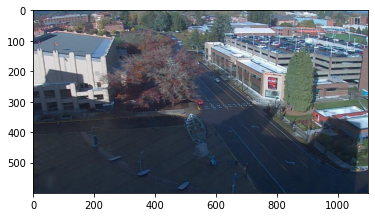

In [37]:
# Visualize misclassified example(s)
# Display an image in the `MISCLASSIFIED` list 
# Print out its predicted label - to see what the image *was* incorrectly classified as
num = 5
test_mis_im = MISCLASSIFIED[num][0]
plt.imshow(test_mis_im)
print(f"{MISCLASSIFIED[num][1]}")

## Add addtional feature extractor

In [46]:
def colors_green_blue(rgb_image):
    # Finds amount of green and blue there is in picture
    # At night there are little green and blue colors

    #convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    #color selection, green and blue
    lower_hue = np.array([90,0,0])
    upper_hue = np.array([135,255,255])
    
    # Define the masked area in HSV space
    mask_hsv = cv2.inRange(hsv, lower_hue, upper_hue)

    #plt.imshow(mask_hsv)
    # Add up all the pixel values in the V channel
    sum_color = np.sum(mask_hsv)

    area = 600*1100.0  # pixels

    #Colors that are green and blue, 0 non, 255 all
    amount = ((sum_color/area)/255)*100
    
    # Return value between 0 and 100
    return amount

In [47]:
# This function should take in RGB image input
def estimate_label(rgb_image):
    
    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
    
    # Extract amount color of green and blue in image
    amount = colors_green_blue(rgb_image)
        
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    
    # Set the value of a threshold that will separate day and night images
    threshold = avg_night_brightness + (avg_day_brightness - avg_night_brightness)/2
    
    # Set the amount of green and blue we expect in daytime
    threshold_2 = 6
    
    if(avg > threshold-5 and amount > threshold_2):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the pred-cted_label can stay 0 (it is predicted to be "night")
    
    return predicted_label

In [48]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

In [49]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.9875
Number of misclassified images = 2 out of 160


0


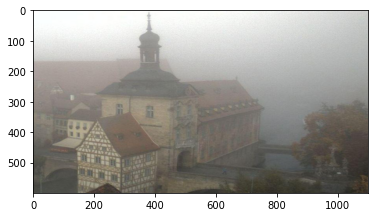

In [52]:

# Visualize misclassified example(s)
# Display an image in the `MISCLASSIFIED` list 
# Print out its predicted label - to see what the image *was* incorrectly classified as
num = 1
test_mis_im = MISCLASSIFIED[num][0]
plt.imshow(test_mis_im)
print(f"{MISCLASSIFIED[num][1]}")